In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K
from experiment_constant import *
import pickle
from experiment_mnist import *
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
dta = MNISTExperiment([10], 0.1, 10, epochs = 0, activation = 'sigmoid', reg_type = 'delta')
x = np.vstack((dta.x_train, dta.x_test))
y = np.vstack((dta.y_train, dta.y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


In [39]:
L = 3
KLips = 2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 10)                7850      
_________________________________________________________________
dense_122 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_123 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_124 (Dense)            (None, 10)                110       
Total params: 8,180
Trainable params: 8,180
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 100/100 [00:25<00:00,  4.24it/s]


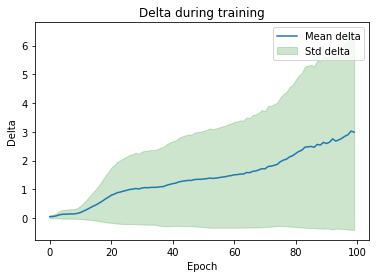

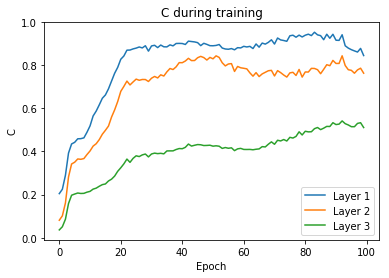

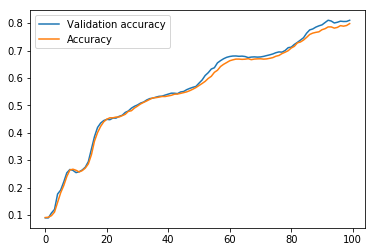

Creating network for 784-dimensional input and 10-dimensional output, with 3 hidden layers


In [69]:
#P = 0.3
P = [0.3] + [0] * (L - 1)
experiment = MNISTExperiment([10] * L, P, KLips, epochs = 100, activation = 'relu', reg_type = 'delta',
                             reg_coeff = 0, do_print = True)
for a, b in zip(experiment.model_no_dropout.get_weights(), experiment.model.get_weights()):
    assert np.allclose(a, b)
weights = experiment.model_no_dropout.get_weights()
W = weights[0::2]
B = weights[1::2]
pickle.dump([W, B], open('mnistnet100percenttightness.pkl', 'wb'))

In [70]:
#[W, B] = pickle.load(open('mnistnet100percenttightness.pkl', 'rb'))
#experiment = ConstantExperiment([28 ** 2, 10, 10, 10, 10, 10, 10], [0.3, 0, 0, 0, 0], 10, W, B, activation = 'relu')

In [71]:
experiment.update_C(x)
mean_bound, std_bound = experiment.get_mean_std_error()

In [72]:
inp = np.random.randn(28 ** 2)
errors = experiment.get_error(inp, repetitions = 100000)
mean_exp = np.mean(np.abs(errors))
print(mean_exp / mean_bound)

0.02884478694753644


In [73]:
experiment.C

[0.854825, 0.7799934, 0.52235866]

100%|██████████| 100/100 [00:01<00:00, 69.47it/s]


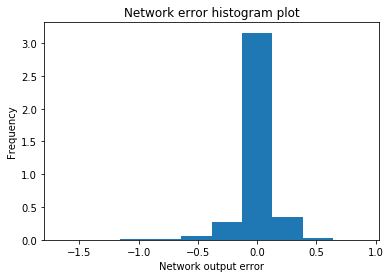

Error; maximal over inputs, average over dropout:
True values array mean: 0.100050 variance 0.221651
Experiment 0.496664 Std 0.530274
Equation   3.026134 Std 3.443143
Tightness  16.4% Std 15.4%


(0.4966644, 0.53027445, 3.0261336995015506, 3.4431429421598683, 0.2216512)

In [74]:
experiment.run(repetitions = 1000, inputs = 100)

In [7]:
#errors = [experiment.get_error(obj, repetitions = 100) for obj in tqdm(x)]

In [8]:
#np.max(np.mean(np.abs(errors), axis = 1))

In [57]:
def calculate_output(exp, x, p = 0.1):
    inp = x
    layers = []
    assert len(exp.W) == len(exp.B)
    for i, (w, b) in enumerate(zip(exp.W, exp.B)):
        if i >= 0:
            dead_neurons = np.where(np.random.rand(w.shape[0]) <= p)[0]
            w = np.copy(w)
            w[dead_neurons, :] = 0
        is_last = i == len(exp.W) - 1
        act = (lambda x : x) if is_last else (lambda x : exp.K * np.maximum(x, 0))
        layers.append(np.max(inp))
        plt.figure()
        plt.title('Activations for layer %d' % i)
        #print(inp)
        plt.hist(inp.reshape(-1))
        xx = np.abs(inp.reshape(-1))
        print(np.mean(xx), np.median(xx))
        plt.show()
        inp = act((inp @ w) + b).reshape(x.shape[0], -1)
    return inp, layers

0.7963218031579156 0.6714158724098459


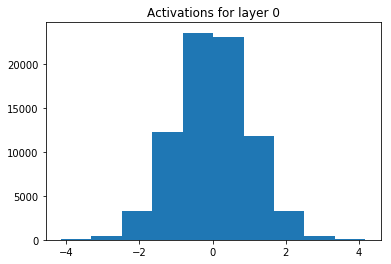

5.1460669829837205 1.4572189445525199


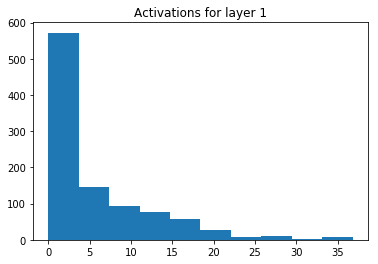

11.272123772897139 0.6773603267706271


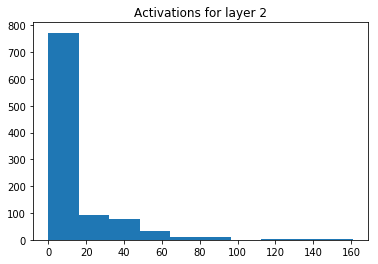

11.448617821620264 0.0


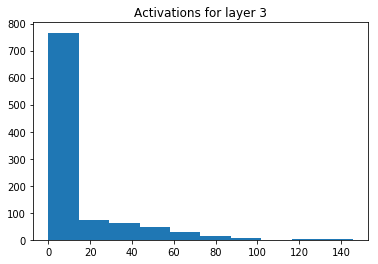

In [58]:
z = calculate_output(experiment, np.random.randn(100, 784), p = 0.5)

In [59]:
experiment.C

[5.843417, 12.915418, 17.976147]

0.13022236994797937 0.0


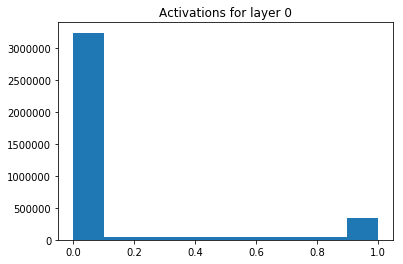

1.652505331294604 1.231355360427908


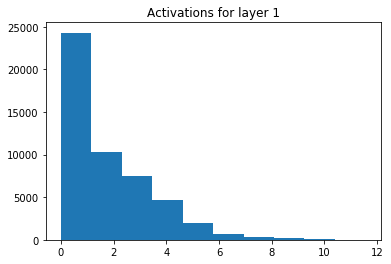

2.0718027665292333 0.8000847286990598


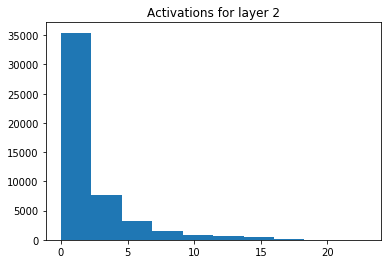

0.7466053837181209 0.43089654008470024


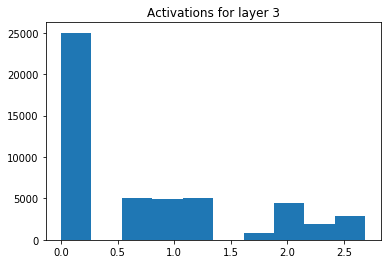

In [62]:
z = calculate_output(experiment, x[:5000, :], p = 0.9)

In [30]:
x[0].shape

(100, 10)

In [23]:
experiment.C

array([49.82485962, 55.65070724])